# Training LightGBM Models

Training LightGBM binary classification models.  
To train LightGBM normaly and exporting onnx model.

In [1]:
# Download titanic.zip from https://www.kaggle.com/competitions/titanic
!unzip titanic.zip

Archive:  titanic.zip
replace gender_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: gender_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [2]:
import polars as pl
import lightgbm as lgb
import numpy as np
from pathlib import Path
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

In [3]:
SEED = 42
USE_COLUMNS = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare"]
CATEGORICAL_COLUMNS = ["Pclass", "Sex"]

MODEL_DIR = Path("models")
MODEL_DIR.mkdir(exist_ok=True)

In [4]:
train_raw = pl.read_csv("train.csv").select(USE_COLUMNS + ["Survived"])
test_raw = pl.read_csv("test.csv").select(USE_COLUMNS)

In [5]:
train_raw.head()

Pclass,Sex,Age,SibSp,Parch,Fare,Survived
i64,str,f64,i64,i64,f64,i64
3,"""male""",22.0,1,0,7.25,0
1,"""female""",38.0,1,0,71.2833,1
3,"""female""",26.0,0,0,7.925,1
1,"""female""",35.0,1,0,53.1,1
3,"""male""",35.0,0,0,8.05,0


In [6]:
test_raw.head()

Pclass,Sex,Age,SibSp,Parch,Fare
i64,str,f64,i64,i64,f64
3,"""male""",34.5,0,0,7.8292
3,"""female""",47.0,1,0,7.0
2,"""male""",62.0,0,0,9.6875
3,"""male""",27.0,0,0,8.6625
3,"""female""",22.0,1,1,12.2875


## Preprocess

Encoding string categorical feature(`Sex` column) to labels.

- `female` : 0
- `male` : 1

In [7]:
train_raw["Sex"].unique()

Sex
str
"""female"""
"""male"""


In [8]:
sex_label_mapping = {
    "female": 0,
    "male": 1,
}

In [9]:
train_numeric = train_raw.with_columns(
    pl.col("Sex").replace_strict(sex_label_mapping).alias("Sex")
)

splitting training dataset for validation.

In [10]:
train, valid = train_test_split(train_numeric, test_size=0.3, random_state=42)
print(f"train size: {train.shape}")
print(f"valid size: {valid.shape}")

train size: (623, 7)
valid size: (268, 7)


In [11]:
y_valid = valid["Survived"].to_numpy()
X_valid = valid.select(pl.exclude("Survived"))
y_train = train["Survived"].to_numpy()
X_train = train.select(pl.exclude("Survived"))

In [12]:
X_train

Pclass,Sex,Age,SibSp,Parch,Fare
i64,i64,f64,i64,i64,f64
1,1,4.0,0,2,81.8583
3,1,null,0,0,7.8958
3,0,1.0,1,1,11.1333
2,1,36.0,1,2,27.75
2,1,43.0,1,1,26.25
…,…,…,…,…,…
3,0,21.0,0,0,7.65
1,1,null,0,0,31.0
3,1,41.0,2,0,14.1083


In [13]:
# Construct as LightGBM Dataset
lgb_train = lgb.Dataset(
    X_train.to_numpy(),
    y_train,
    feature_name=USE_COLUMNS,
)
lgb_valid = lgb.Dataset(
    X_valid,
    y_valid,
    reference=lgb_train,
)

In [14]:
# custom metric to calc f1-score
def f1(preds: np.ndarray, data: lgb.Dataset, threshold: float=0.5):
    label = data.get_label()
    pred_label = (preds > threshold).astype(int)
    score = f1_score(pred_label, label, average='macro')
    return 'f1', score, True

In [15]:
params = {"num_leaves": 5, "metric": ["binary_logloss", "binary_error"], "verbose": -1, "objective": "binary"}

In [16]:
model = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=[lgb_train, lgb_valid],
    feval=f1,
    callbacks=[lgb.log_evaluation(10)],
)

[10]	training's binary_logloss: 0.463302	training's binary_error: 0.194222	training's f1: 0.764048	valid_1's binary_logloss: 0.485355	valid_1's binary_error: 0.227612	valid_1's f1: 0.741227
[20]	training's binary_logloss: 0.411401	training's binary_error: 0.158909	training's f1: 0.816517	valid_1's binary_logloss: 0.442972	valid_1's binary_error: 0.190299	valid_1's f1: 0.79057
[30]	training's binary_logloss: 0.388313	training's binary_error: 0.149278	training's f1: 0.829894	valid_1's binary_logloss: 0.427774	valid_1's binary_error: 0.19403	valid_1's f1: 0.789002
[40]	training's binary_logloss: 0.37342	training's binary_error: 0.144462	training's f1: 0.834742	valid_1's binary_logloss: 0.42289	valid_1's binary_error: 0.208955	valid_1's f1: 0.770604
[50]	training's binary_logloss: 0.362016	training's binary_error: 0.141252	training's f1: 0.838833	valid_1's binary_logloss: 0.42251	valid_1's binary_error: 0.19403	valid_1's f1: 0.789002
[60]	training's binary_logloss: 0.351851	training's bina

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

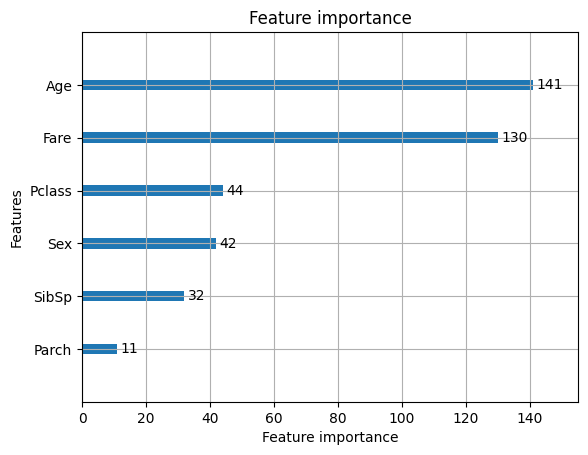

In [17]:
lgb.plot_importance(model)

In [18]:
model.save_model(MODEL_DIR / "titanic_lgb_model.txt")

## LightGBM Model Export to ONNX

refer to https://zenn.dev/potato_iidx/articles/528b3a4a4002f9

In [19]:
!pip install onnxmltools onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.5/352.5 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 95.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 76.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 4.4 MB/s eta 0:00:00


In [20]:
import onnxmltools
from onnxmltools.convert.common.data_types import FloatTensorType

In [21]:
# Convert LightGBM model into onnx
onnx_model = onnxmltools.convert_lightgbm(
    model,
    initial_types=[("inputs", FloatTensorType([None, len(USE_COLUMNS)]))],
    zipmap=False,  # set to False from onnxruntime issue-5292: https://github.com/microsoft/onnxruntime/issues/5292
)

In [22]:
onnxmltools.utils.save_model(onnx_model, MODEL_DIR / "titanic_lgb.onnx")

## Comparison between Original and ONNX outputs


In [23]:
# preprocess
test_numeric = test_raw.with_columns(
    pl.col("Sex").replace_strict(sex_label_mapping).alias("Sex")
)

In [24]:
# For original model prediction
lgb_pred_prob = model.predict(test_numeric.to_numpy())

In [25]:
# conver into 0/1 value
lgb_predictions = (lgb_pred_prob > 0.5).astype(int)

In [26]:
lgb_predictions

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [27]:
import onnxruntime as rt

In [28]:
# For onnx model prediction
sess = rt.InferenceSession(MODEL_DIR / "titanic_lgb.onnx")

input_data = np.array(test_numeric, dtype=np.float32)
input_name = sess.get_inputs()[0].name

# Make predictions using the ONNX model
output_name = sess.get_outputs()[0].name
lgbm_onnx_predictions = sess.run([output_name], {input_name: input_data})[0]

In [29]:
lgbm_onnx_predictions

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [30]:
# if output `True` means all predicted values are exact same.
np.array_equal(lgbm_onnx_predictions, lgb_predictions)

True